In [58]:
import os
import argparse
from solver import Solver
from solver_ver2 import Solver_ver2
from data_loader import get_loader, get_re_id_loader
from torch.backends import cudnn
from data_loader import CelebA
from torchvision import transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import re
import torchvision.transforms as transforms
import copy
def str2bool(v):
    return v.lower() in ('true')

In [2]:
parser = argparse.ArgumentParser()
# Model configuration.
parser.add_argument('--c_dim', type=int, default=14, help='dimension of domain labels (1st dataset)')
parser.add_argument('--c2_dim', type=int, default=8, help='dimension of domain labels (2nd dataset)')
parser.add_argument('--celeba_crop_size', type=int, default=178, help='crop size for the CelebA dataset')
parser.add_argument('--rafd_crop_size', type=int, default=256, help='crop size for the RaFD dataset')
parser.add_argument('--reid_crop_size', type=int, default=256, help='crop size for the PersonReID dataset')
parser.add_argument('--image_size', type=int, default=286, help='image resolution')
parser.add_argument('--g_conv_dim', type=int, default=64, help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=64, help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_seg', type=float, default=0.5, help='weight for segmentation loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')

# Training configuration.
parser.add_argument('--dataset', type=str, default='CelebA', choices=['CelebA', 'RaFD', 'Both', 'PersonReID'])
parser.add_argument('--parsing', action='store_true')
parser.add_argument('--batch_size', type=int, default=1, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=200000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=100000, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')
parser.add_argument('--selected_attrs', '--list', nargs='+', help='selected attributes for the CelebA dataset',
                    default=['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'])

# Test configuration.
parser.add_argument('--test_iters', type=int, default=200000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='test', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=True)

# Directories.
parser.add_argument('--celeba_image_dir', type=str, default='data/celeba/images')
parser.add_argument('--reid_image_dir', type=str, default='/home/jun/ReID_Dataset')
parser.add_argument('--attr_path', type=str, default='data/celeba/list_attr_celeba.txt')
parser.add_argument('--rafd_image_dir', type=str, default='data/RaFD/train')
parser.add_argument('--log_dir', type=str, default='test/logs')
parser.add_argument('--model_save_dir', type=str, default='test/models')
parser.add_argument('--sample_dir', type=str, default='test/samples')
parser.add_argument('--result_dir', type=str, default='test/results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--device', type=int, default=0)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=10000)
parser.add_argument('--lr_update_step', type=int, default=1000)

config = parser.parse_args('')

In [3]:
print(config)

Namespace(c_dim=14, c2_dim=8, celeba_crop_size=178, rafd_crop_size=256, reid_crop_size=256, image_size=286, g_conv_dim=64, d_conv_dim=64, g_repeat_num=6, d_repeat_num=6, lambda_cls=1, lambda_rec=10, lambda_seg=0.5, lambda_gp=10, dataset='CelebA', parsing=False, batch_size=1, num_iters=200000, num_iters_decay=100000, g_lr=0.0001, d_lr=0.0001, n_critic=5, beta1=0.5, beta2=0.999, resume_iters=None, selected_attrs=['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'], test_iters=200000, num_workers=1, mode='test', use_tensorboard=True, celeba_image_dir='data/celeba/images', reid_image_dir='/home/jun/ReID_Dataset', attr_path='data/celeba/list_attr_celeba.txt', rafd_image_dir='data/RaFD/train', log_dir='test/logs', model_save_dir='test/models', sample_dir='test/samples', result_dir='test/results', log_step=10, device=0, sample_step=1000, model_save_step=10000, lr_update_step=1000)


In [4]:
# For fast training.
cudnn.benchmark = True

# Create directories if not exist.
if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)
if not os.path.exists(config.model_save_dir):
    os.makedirs(config.model_save_dir)
if not os.path.exists(config.sample_dir):
    os.makedirs(config.sample_dir)
if not os.path.exists(config.result_dir):
    os.makedirs(config.result_dir)

In [5]:
celeba_loader = None
rafd_loader = None
personreid_loader = get_re_id_loader(config.reid_image_dir, 
                                 config.reid_crop_size, config.image_size, config.batch_size,
                                 config.mode, config.num_workers) 

=> Market1501 loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
This dataset has been downloaded.
=> DukeMTMC-reID loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   702 |    16522 |         8
  query    |   702 |     2228 |         8
  gallery  |  1110 |    17661 |         8
  ----------------------------------------


In [123]:
solver = Solver(celeba_loader, rafd_loader, personreid_loader, config)
solver.G.load_state_dict(torch.load('/home/jun/stargan/checkpoints/personreid_parsing_0.5/models/400000-G.ckpt', map_location='cuda:0'))
solver.G.to(solver.device)

Generator(
  (main): Sequential(
    (0): Conv2d(17, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Generator(
  (main): Sequential(
    (0): Conv2d(17, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
data = next(iter(personreid_loader))

In [8]:
data[0], data[1].shape, data[2]

(('/home/jun/ReID_Dataset/Market-1501-v15.09.15/bounding_box_train/1049_c6s2_129993_01.jpg',),
 torch.Size([1, 3, 256, 256]),
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [102]:
# Function to convert tensor to image for displaying
def tensor_to_image(tensor):
    tensor = tensor.clone().detach().cpu()  # Clone the tensor to avoid modifying the original and move to CPU
    tensor = F.interpolate(tensor, size=[256,128], mode='bilinear', align_corners=False)
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # De-normalize
    tensor = tensor.permute(1, 2, 0)  # Change from CxHxW to HxWxC
    tensor = tensor.numpy()  # Convert to numpy array
    tensor = (tensor * 255).astype(np.uint8)  # Convert to uint8
    return tensor 

crop_size_w = 256
crop_size_h = 256

transform = transforms.Compose([
    transforms.Resize((crop_size_h, crop_size_w), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [41]:
raw_data_dir_market1501 = Path('/home/jun/ReID_Dataset/DukeMTMC-reID')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
market_train_dic = {i.name:i for i in sorted(list(raw_data_dir_market1501.glob('bounding_box_train/*.jpg')))}
market_gallery_dic = {i.name:i for i in sorted(list(raw_data_dir_market1501.glob('bounding_box_test/*.jpg')))}
market_query_dic = {i.name:i for i in sorted(list(raw_data_dir_market1501.glob('query/*.jpg')))}


torch.Size([1, 3, 256, 256])
torch.Size([1, 14])


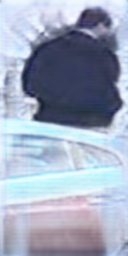

In [134]:
image_path = list(market_train_dic.values())[700]
image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
# Apply the transformations
transformed_image = transform(image)
#solver.G.eval()
x = transformed_image.unsqueeze(0).to(solver.device)
print(x.shape)
camid_one_hot_vector = torch.zeros(14)
camid_one_hot_vector[9] = 1 
label = camid_one_hot_vector.unsqueeze(0).to(solver.device)
print(label.shape)
y = solver.G(x,label)
output_image = tensor_to_image(y)
output_image = Image.fromarray(output_image)
output_image

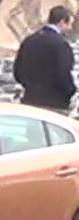

In [131]:
image

In [56]:
raw_data_dir_market1501 = Path('/home/jun/ReID_Dataset/DukeMTMC-reID')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
market_train_dic = {i.name:i for i in sorted(list(raw_data_dir_market1501.glob('bounding_box_train/*.jpg')))}
market_gallery_dic = {i.name:i for i in sorted(list(raw_data_dir_market1501.glob('bounding_box_test/*.jpg')))}
market_query_dic = {i.name:i for i in sorted(list(raw_data_dir_market1501.glob('query/*.jpg')))}

cam_num = 6

for i in range(cam_num):

    new_data_dir_market1501 = Path(f'/home/jun/ReID_Dataset/DukeMTMC-reID-stargan-cam{i}')
    new_data_dir_market1501.mkdir(exist_ok=True)
    new_market_train_dir = new_data_dir_market1501 / 'bounding_box_train'
    new_market_train_dir.mkdir(exist_ok=True)
    new_market_gallery_dir = new_data_dir_market1501 / 'bounding_box_test'
    new_market_gallery_dir.mkdir(exist_ok=True)
    new_market_query_dir = new_data_dir_market1501 / 'query'
    new_market_query_dir.mkdir(exist_ok=True)

    print(f'Making {str(new_data_dir_market1501)}')
    
    for image_name, image_path in market_train_dic.items():
        image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
        # Apply the transformations
        transformed_image = transform(image)
        solver.G.eval()
        x = transformed_image.unsqueeze(0).to(solver.device)
        camid_one_hot_vector = torch.zeros(14)
        camid_one_hot_vector[i] = 1 
        label = camid_one_hot_vector.unsqueeze(0).to(solver.device)
        with torch.no_grad():
            y = solver.G(x,label)
        output_image = tensor_to_image(y)
        output_image = Image.fromarray(output_image)
        output_image_path = new_market_train_dir / image_name
        output_image.save(output_image_path)

Making /home/jun/ReID_Dataset/DukeMTMC-reID-stargan-cam0
Making /home/jun/ReID_Dataset/DukeMTMC-reID-stargan-cam1


KeyboardInterrupt: 

In [21]:
raw_data_dir_market1501 = Path('/home/jun/ReID_Dataset/Market-1501-v15.09.15')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
market_train_dic = {i.name:i for i in sorted(list(raw_data_dir_market1501.glob('bounding_box_train/*.jpg')))}
market_gallery_dic = {i.name:i for i in sorted(list(raw_data_dir_market1501.glob('bounding_box_test/*.jpg')))}
market_query_dic = {i.name:i for i in sorted(list(raw_data_dir_market1501.glob('query/*.jpg')))}

cam_num = 8

for i in range(cam_num):

    new_data_dir_market1501 = Path(f'/home/jun/ReID_Dataset/Market-1501-v15.09.15-stargan-cam{i}')
    new_data_dir_market1501.mkdir(exist_ok=True)
    new_market_train_dir = new_data_dir_market1501 / 'bounding_box_train'
    new_market_train_dir.mkdir(exist_ok=True)
    new_market_gallery_dir = new_data_dir_market1501 / 'bounding_box_test'
    new_market_gallery_dir.mkdir(exist_ok=True)
    new_market_query_dir = new_data_dir_market1501 / 'query'
    new_market_query_dir.mkdir(exist_ok=True)

    print(f'Making {str(new_data_dir_market1501)}')
    
    for image_name, image_path in market_train_dic.items():
        image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
        # Apply the transformations
        transformed_image = transform(image)
        solver.G.eval()
        x = transformed_image.unsqueeze(0).to(solver.device)
        camid_one_hot_vector = torch.zeros(14)
        camid_one_hot_vector[i+6] = 1 
        label = camid_one_hot_vector.unsqueeze(0).to(solver.device)
        with torch.no_grad():
            y = solver.G(x,label)
        output_image = tensor_to_image(y)
        output_image = Image.fromarray(output_image)
        output_image_path = new_market_train_dir / image_name
        output_image.save(output_image_path)

Making /home/jun/ReID_Dataset/Market-1501-v15.09.15-stargan-cam0


KeyboardInterrupt: 

In [12]:
for data in personreid_loader:
    if data[0][0].find('Market') != -1:
        
        image_path = Path(data[0][0])
        image_name = image_path.name
        image = data[1].to(solver.device)
        '''
        output_image_path = new_market_train_dir / image_name
        #print(f'Saving {output_image_path}')
        output_image = Image.fromarray(tensor_to_image(image))
        output_image.save(output_image_path)
        '''
        for i in range(6,14):
            image = image.to(solver.device)
            new_image_name = re.sub(r'c\d', f'c{i}', image_name)
            output_image_path = new_market_train_dir / new_image_name 
            #print(f'Saving {output_image_path}')
            camid_one_hot_vector = torch.zeros(14)
            camid_one_hot_vector[i] = 1 
            label = camid_one_hot_vector.unsqueeze(0).to(solver.device)
            with torch.inference_mode(): 
                output_image = solver.G(image,label)
            output_image = Image.fromarray(tensor_to_image(output_image))
            output_image.save(output_image_path) 
    elif data[0][0].find('Duke') != -1:
        pass
        image_path = Path(data[0][0])
        image_name = image_path.name
        image = data[1].to(solver.device)
        '''
        output_image_path = new_duke_train_dir / image_name
        print(f'Saving {output_image_path}')
        output_image = Image.fromarray(tensor_to_image(image))
        output_image.save(output_image_path)
        ''' 
        for i in range(0,6):
            image = image.to(solver.device)
            new_image_name = re.sub(r'c\d', f'c{i}', image_name)
            output_image_path = new_duke_train_dir / new_image_name 
            #print(f'Saving {output_image_path}')
            camid_one_hot_vector = torch.zeros(14)
            camid_one_hot_vector[i] = 1 
            label = camid_one_hot_vector.unsqueeze(0).to(solver.device) 
            with torch.inference_mode(): 
                output_image = solver.G(image,label)
            output_image = Image.fromarray(tensor_to_image(output_image))
            output_image.save(output_image_path) 

KeyboardInterrupt: 

In [ ]:
for i in range(6,14):
    print(i)

6
7
8
9
10
11
12
13


In [149]:
data = next(iter(personreid_loader))
image_path = Path(data[0][0])
image_name = image_path.name
image = data[1].to(solver.device)
label = data[2].to(solver.device)
print(image.shape, label.shape)
camid_one_hot_vector = torch.zeros(14)
camid_one_hot_vector[14] = 1 
label = camid_one_hot_vector.unsqueeze(0).to(solver.device)
output_image = solver.G(image,label)
print(output_image.shape)
output_image = tensor_to_image(output_image)
output_image = Image.fromarray(output_image)
output_image

torch.Size([1, 3, 256, 256]) torch.Size([1, 14])


IndexError: index 14 is out of bounds for dimension 0 with size 14

: 

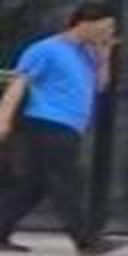

In [112]:
image = tensor_to_image(image)
image = Image.fromarray(image)
image